# Stiffness Maximization of a Console in 3d

We have a simple console with a rectangular cross section subject to known loads, in this case a concentrated force actgin on the free end. What we want is to determine the topology that makes the stiffest structure, given that material usage is limited as a fraction of the original volume. 

The workflow is governed by the following parameters:

In [1]:
# problem parameters
L = 50.  # length of the console
w, h = 10., 10.  # width and height of the rectangular cross section
resulution = (24, 6, 6)  # resolution of the result in all 3 directions
F = -100.  # value of the vertical load at the free end
E = 21000.0  # Young's modulus
nu = 0.2  # Poisson's ratio

# oc parameters
volume_fraction = 0.8
ftol = 0.9
nIter = 80


## Initial Solution

To verify the density of the mesh and to mark our starting point, we run a linear analysis on the virgin structure. In this particular case, a simple analytic solution is available that helps to judge if our mesh is dense enough to produce accurate results or not. 

The properties of the cross section and the analytic solution:

In [2]:
import numpy as np

# cross section
A = w * h  # area
Iy = w * h**3 / 12  # second moment of inertia around the y axis
Iz = w * h**3 / 12  # second moment of inertia around the z axis
Ix = Iy + Iz  # torsional inertia

# Analytic solution
EI = E * Iy
sol_exact = F * L**3 / (3 * EI)
tol = np.abs(sol_exact / 1000)
sol_exact


-0.23809523809523808

Numerical solution for the deflection of the free end using 3d solid elements. Here we used triliear Q4 cells, which are actually regarded as having poor performance, but since we are using a pretty dense mesh to have a suffucuent number of design variables, quantity wins here.

In [3]:
from sigmaepsilon.solid import Structure, PointData, SolidMesh as FemMesh
from sigmaepsilon.solid.fem.cells import H8 as Cell
from polymesh.space import StandardFrame
from polymesh.grid import gridH8 as grid
from neumann import repeat, minmax
from colorama import Fore
from latexdocs.utils import floatformatter

f2s4 = floatformatter(sig=4)
def frmt4(v): return f2s4.format(v)


size = Lx, Ly, Lz = (L, w, h)
shape = nx, ny, nz = resulution

gridparams = {
    'size': size,
    'shape': shape,
    'origo': (0, 0, 0),
    'start': 0
}

coords, topo = grid(**gridparams)

A = np.array([
    [1, nu, nu, 0, 0, 0],
    [nu, 1, nu, 0, 0, 0],
    [nu, nu, 1, 0, 0, 0],
    [0., 0, 0, (1-nu)/2, 0, 0],
    [0., 0, 0, 0, (1-nu)/2, 0],
    [0., 0, 0, 0, 0, (1-nu)/2]]) * (E / (1-nu**2))
hooke = repeat(A, topo.shape[0])

# fix points at x==0
cond = coords[:, 0] <= 0.001
ebcinds = np.where(cond)[0]
fixity = np.zeros((coords.shape[0], 3), dtype=bool)
fixity[ebcinds, :] = True

# unit vertical load at (Lx, Ly)
cond = (coords[:, 0] > (Lx-(1e-12))) & \
    (np.abs(coords[:, 1] - (Ly/2)) < 1e-12) & \
    (np.abs(coords[:, 2] - (Lz/2)) < 1e-12)
nbcinds = np.where(cond)[0]
loads = np.zeros((coords.shape[0], 3))
loads[nbcinds, 2] = F

GlobalFrame = StandardFrame(dim=3)

# pointdata
pd = PointData(coords=coords, frame=GlobalFrame,
               loads=loads, fixity=fixity)

# celldata
frames = repeat(GlobalFrame.show(), topo.shape[0])
cd = Cell(topo=topo, frames=frames, material=hooke)

# set up mesh and structure
mesh = FemMesh(pd, cd, frame=GlobalFrame)
structure = Structure(mesh=mesh)

structure.linear_static_analysis()
dofsol = structure.nodal_dof_solution()
structure.mesh.pointdata['x'] = coords + dofsol[:, :3]
sol_fem_3d = dofsol[:, 2].min()
sol_fem_3d


-0.25853247862948847

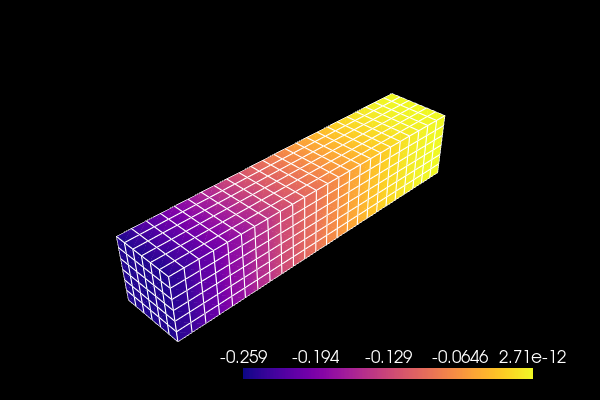

In [4]:
from pyvista import themes

my_theme = themes.DarkTheme()
my_theme.color = 'red'
my_theme.lighting = False
my_theme.show_edges = True
my_theme.axes.box = True

mesh.config['pyvista', 'plot', 'scalars'] = dofsol[:, 2]
mesh.pvplot(notebook=True, jupyter_backend='static', window_size=(600, 400),
            config_key=('pyvista', 'plot'), cmap='plasma', theme=my_theme)


If the values after this code block are printed with red, the mesh is not dense enough to yield reliable results.

In [5]:
sol_fem_3d
w0 = sol_exact
w1 = sol_fem_3d
dw = 100 * (w1 - w0) / w0
msg = "Analytical : {} \nFEM : {} ({}%)".format(
    frmt4(w0), frmt4(w1), frmt4(dw))
if dw < 2.0:
    print(Fore.GREEN + msg)
else:
    print(Fore.RED + msg)


Analytical : -0.2381 
FEM : -0.2585 (8.584%)


## Optimize the Topology for Stiffness

We are going to use an `Optimality Criteria Method` to solve our optimization problem in 3 phases. Also, create a dictionary to store some stats during the phases.

In [6]:
from sigmaepsilon.solid.topopt.oc import maximize_stiffness
from linkeddeepdict import LinkedDeepDict

history = LinkedDeepDict(dict(vol=[], obj=[], pen=[], x=[]))

knn6 = structure.mesh.k_nearest_cell_neighbours(6)


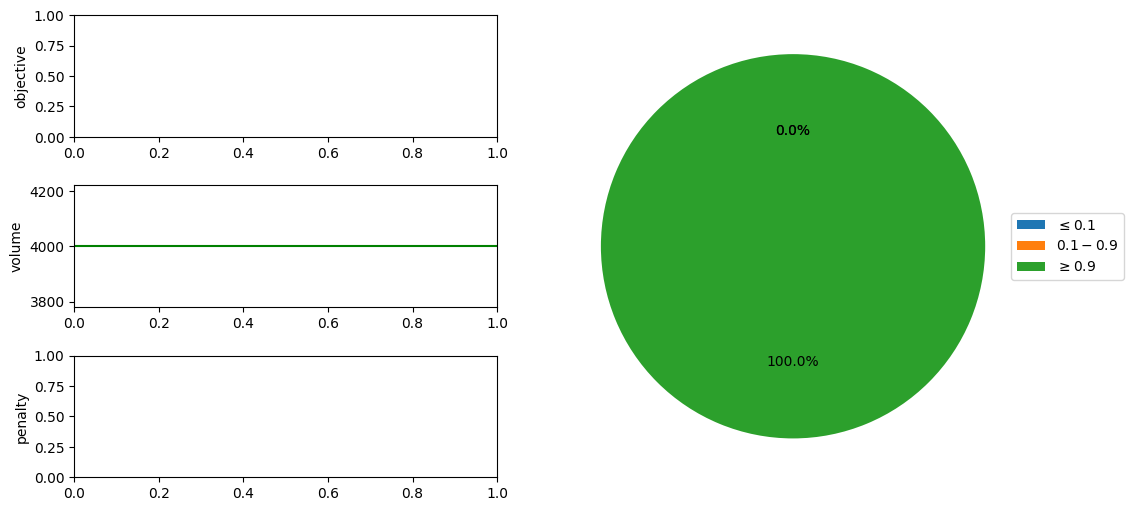

In [7]:
from neumann import histogram
from matplotlib import gridspec
import matplotlib as mpl
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

plt.ioff()

fig = plt.figure(figsize=(12, 6))  # in inches
fig.patch.set_facecolor('white')
gs = gridspec.GridSpec(3, 2, width_ratios=[1, 1], hspace=0.4,
                       height_ratios=[1, 1, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_ylabel('objective')

ax2 = fig.add_subplot(gs[1, 0])
ax2.set_ylabel('volume')
ax2.axhline(y = mesh.volume() * volume_fraction, 
            color = 'g', linestyle = '-')

ax3 = fig.add_subplot(gs[2, 0])
ax3.set_ylabel('penalty')

ax4 = fig.add_subplot(gs[:, 1])

bins = [0.0, 0.1, 0.9, 1.0]
labels = r'$\leq 0.1$', r'$0.1 - 0.9$', r'$\geq 0.9$'
sizes = [0, 0, 1]
wedges, texts, autotext = \
    ax4.pie(sizes, autopct='%1.1f%%', startangle=90)
ax4.axis('equal')
ax4.legend(wedges, labels,
           loc="center left",
           bbox_to_anchor=(1, 0, 0.5, 1))


def update_mpl(i, obj, vol, pen, x):
    """ax1.plot(i, obj, marker='o', c='b', markersize='2')
    ax2.plot(i, vol, marker='*', c='g', markersize='2')
    ax3.plot(i, pen, marker='*', c='g', markersize='2')"""
    if i == 0:
        ax1.plot(i, obj, c='r', marker='o', markersize='7')
        ax2.plot(i, vol, c='r', marker='o', markersize='7')
        ax3.plot(i, pen, c='r', marker='o', markersize='7')
    else:
        ax1.plot([i-1, i], [history['obj'][-1], obj], c='b')
        ax2.plot([i-1, i], [history['vol'][-1], vol], c='b')
        ax3.plot([i-1, i], [history['pen'][-1], pen], c='b')

    ax4.cla()
    hist, _ = histogram(x, bins)
    hist = hist.astype(float)
    hist /= hist.max()
    wedges, *_ = ax4.pie(hist, autopct='%1.1f%%',
                         startangle=90)
    ax4.axis('equal')
    ax4.legend(wedges, labels,
               loc="center left",
               bbox_to_anchor=(1, 0, 0.5, 1))

    display(fig)
    clear_output(wait=True)
    plt.pause(0.1)


### Phase 1 - Shape Optimization

Firts we perform an optimization without penalizing intermadiate values in the density distribution. After this step, elements with smallest densities are cut off and a smaller substructure is detached to speed up subsequent calculations.

In [8]:
# iteration parameters
OC_params = {
    'p_start': 1.0,  # SIMP penalty factor
    'p_inc': 0.0,
    'q': 0.5,  # smoothing factor
    'vfrac': volume_fraction,
    'dtol': 0.3,  # to control maximum change in the variables
    'miniter': 30,
    'maxiter': 1e12
}
optimizer = maximize_stiffness(structure, **OC_params)
r = next(optimizer)
history['obj'].append(r.obj)
history['vol'].append(r.vol)
history['pen'].append(r.pen)

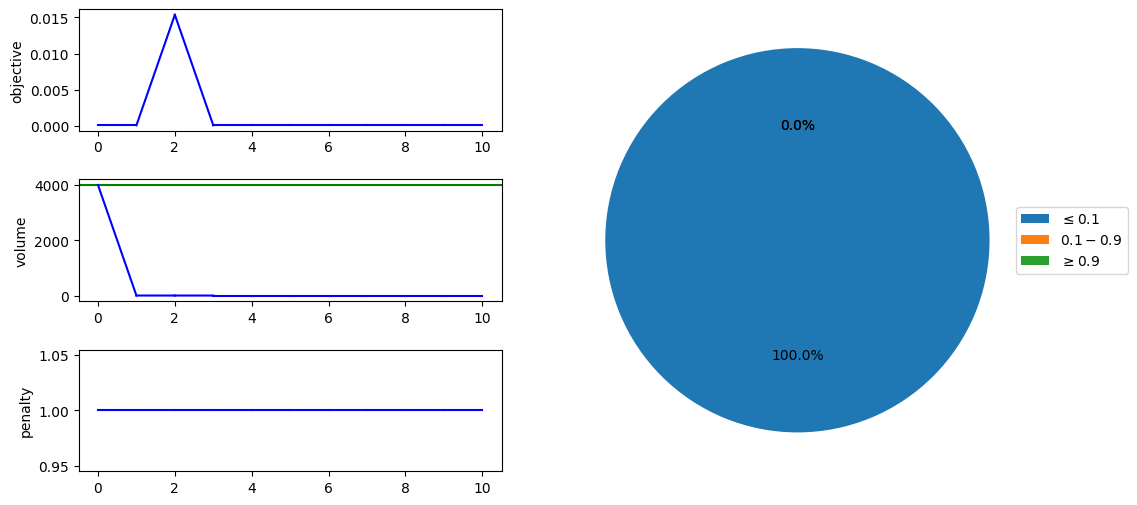

In [9]:
plt.ion()
for _ in range(10):
    r = next(optimizer)
    update_mpl(r.n, r.obj, r.vol, r.pen, r.x)
    history['obj'].append(r.obj)
    history['vol'].append(r.vol)
    history['pen'].append(r.pen)


### Phase 2 - Topology Optimization

In [10]:
# iteration parameters
OC_params = {
    'p_start': 1.0,  # SIMP penalty factor
    'p_stop': 3.0,
    'p_inc': 0.2,
    'p_step': 5,
    'q': 0.5,  # smoothing factor
    'vfrac': volume_fraction,
    'dtol': 0.1,  # to control maximum change in the variables
    'miniter': 30,
    'maxiter': 1e12,
}
OC_params['neighbours'] = structure.mesh.k_nearest_cell_neighbours(6)
optimizer = maximize_stiffness(structure, guess=r.x, i_start=r.n + 1, **OC_params)
for _ in range(nIter):
    r = next(optimizer)
    update_mpl(r.n, r.obj, r.vol, r.pen, r.x)
    history['obj'].append(r.obj)
    history['vol'].append(r.vol)
    history['pen'].append(r.pen)

AssertionError: Mismatch in shape

### Phase 3 - Postprocessing

In [107]:
from polymesh.utils.topology import detach

i = np.where(r.x >= ftol)[0]
coords = mesh.coords()
topo = mesh.topology()
coords, topo = detach(coords, topo[i])


In [108]:
from polymesh.utils.space import index_of_closest_point

hooke = repeat(A, topo.shape[0])

# fix points at x==0
cond = coords[:, 0] <= 0.001
ebcinds = np.where(cond)[0]
fixity = np.zeros((coords.shape[0], 3), dtype=bool)
fixity[ebcinds, :] = True

# unit vertical load at (Lx, Ly)
i = index_of_closest_point(coords, np.array([Lx, Ly/2, Lz/2]))
loads = np.zeros((coords.shape[0], 3))
loads[i, 2] = F

# pointdata
pd = PointData(coords=coords, frame=GlobalFrame,
               loads=loads, fixity=fixity)

# celldata
frames = repeat(GlobalFrame.show(), topo.shape[0])
cd = Cell(topo=topo, frames=frames)

# set up mesh and structure
mesh_opt = FemMesh(pd, cd, model=hooke, frame=GlobalFrame)
structure = Structure(mesh=mesh_opt)

structure.linsolve()
dofsol = structure.nodal_dof_solution()
sol_fem_3d_opt = dofsol[:, 2].min()


In [109]:
w0 = sol_fem_3d*F
w_opt = sol_fem_3d_opt*F
w0, w_opt, 100 * w_opt/w0


(27.396923229593504, 36.50314092549638, 133.23810348917777)

In [110]:
v0 = mesh.volume()
v_opt = mesh_opt.volume()
v0, v_opt, 100 * v_opt/v0


(5000.13915554286, 2319.4427009577394, 46.38756300185249)

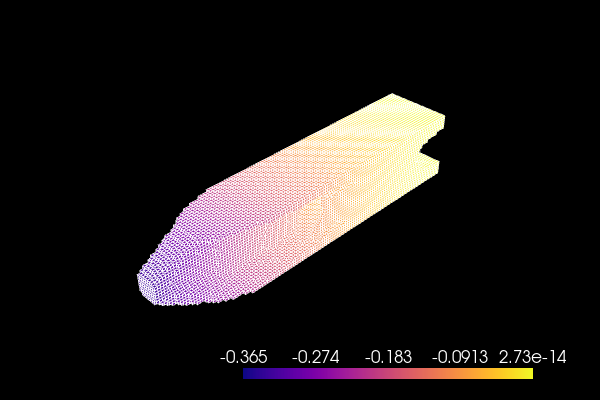

In [111]:
mesh_opt.config['pyvista', 'plot', 'scalars'] = dofsol[:, 2]
mesh_opt.pvplot(notebook=True, jupyter_backend='static', window_size=(600, 400),
                config_key=('pyvista', 'plot'), cmap='plasma', theme=my_theme)


In [112]:
v0 = mesh.volume()
v1 = mesh_opt.volume()
dv = 100 * (v1 - v0) / v0
msg = "Change in volume : {} -> {} ({}%)".format(
    frmt4(v0), frmt4(v1), frmt4(dv))
print(Fore.BLUE + msg)

w0 = sol_fem_3d*F
w1 = sol_fem_3d_opt*F
dw = 100 * (w1 - w0) / w0
msg = "Change in compliance : {} -> {} ({}%)".format(
    frmt4(w0), frmt4(w1), frmt4(dw))
print(Fore.BLUE + msg)


Change in volume : 5000 -> 2319 (-53.61%)
Change in compliance : 27.4 -> 36.5 (33.24%)


In [113]:
mesh_opt.plot()
